In [7]:
import json
import random
import numpy as np
import pandas as pd
from operator import itemgetter
from openpyxl import load_workbook
import math

global or_dist_sum, dist_or_matrix

global or_dist_sum, dist_or_matrix
or_dist_sum = 0
dist_or_matrix = [[0 for x in range(len(original))] for y in range(len(original))]
for i in range(len(original)):
    for j in range(i + 1, len(original)):
        dist_or = np.linalg.norm(original[i] - original[j])
        dist_or_matrix[i][j] = dist_or
        or_dist_sum += dist_or



In [2]:
class Particle:
    def __init__(self, size):
        self.position = []          # particle position
        self.velocity = []          # particle velocity
        self.pos_best = []          # best position individual
        self.err_best = -1          # best error individual
        self.err = -1               # error individual

        for i in range(size):
            self.velocity.append(random.uniform(-1, 1))
            self.position.append(random.uniform(0, 1))

    # evaluate current fitness
    def evaluate(self, func, original, select_num):
        pos = project_position(original, self.position, select_num)
        self.err = func(pos)

        # check to see if the current position is an individual best
        if self.err < self.err_best or self.err_best == -1:
            self.pos_best = self.position
            self.err_best = self.err

    # update new particle velocity
    def update_velocity(self, global_pos_best, size, W=0.6, C1=1, C2=2):
        w = W       # constant inertia weight (how much to weigh the previous velocity)
        c1 = C1        # cognative constant
        c2 = C2        # social constant

        for i in range(size):
            r1 = random.random()
            r2 = random.random()

            vel_cognitive = c1*r1*(self.pos_best[i]-self.position[i])
            vel_social = c2*r2*(global_pos_best[i]-self.position[i])
            self.velocity[i] = w*self.velocity[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self, bounds, size):
        for i in range(0, size):
            self.position[i] = self.position[i] + self.velocity[i]

            # adjust maximum position if necessary
            if self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]

            # adjust minimum position if neseccary
            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]


# Particle Swarm Optimization for feature selection
class PSO:
    def __init__(self, func, original, bounds, num_particles, maxiter, select_num, W, C1, C2):

        num_dimensions = len(original[0])
        self.err_best_g = -1  # best error for group
        self.pos_best_g = []
        self.select_num = select_num

        # establish the swarm
        swarm = []
        for i in range(num_particles):
            swarm.append(Particle(num_dimensions))

        # begin optimization loop
        i = 0
        while i < maxiter:
            # cycle through particles in swarm and evaluate fitness
            for j in range(num_particles):
                swarm[j].evaluate(func, original, select_num)

                # determine if current particle is the best (globally)
                if swarm[j].err < self.err_best_g or self.err_best_g == -1:
                    self.pos_best_g = list(swarm[j].position)
                    self.err_best_g = float(swarm[j].err)

            # cycle through swarm and update velocities and position
            for j in range(num_particles):
                swarm[j].update_velocity(self.pos_best_g, num_dimensions, W, C1, C2)
                swarm[j].update_position(bounds, num_dimensions)
            i += 1

    def get_result(self):
        position = np.array(self.pos_best_g)
        sorted_index_arr = np.argsort(position)
        rslt = sorted_index_arr[-self.select_num:]
        rslt.sort()
        return {
            'features_num': self.select_num,
            'features_idxs': rslt,
            'error': self.err_best_g
        }


def sammon_error(projected):
    global dist_or_matrix, or_dist_sum
    diff_sum = 0
    for i in range(len(projected)):
        for j in range(i + 1, len(projected)):
            diff_sum += ((dist_or_matrix[i][j] - np.linalg.norm(projected[i] - projected[j])) ** 2) / dist_or_matrix[i][j]
    return (1 / or_dist_sum) * diff_sum


# select particular features from original dataset
def project_position(original, position, select_num):
    position = np.array(position)
    sorted_index_arr = np.argsort(position)
    rslt = sorted_index_arr[-select_num:]
    rslt.sort()
    projection = original[:, rslt]
    return projection


def interpret_results(json_filename, data_filename, xlsx_filename):
    data = pd.read_csv(data_filename)
    with open(json_filename) as json_file:
        json_results = json.load(json_file)
    wb = load_workbook(xlsx_filename)
    sheet = wb.active
    sheet.cell(1, 1, 'Number of metrics')
    sheet.cell(1, 2, 'Error')
    i = 3
    for d in data:
        sheet.cell(1, i, d)
        i += 1
    for i in range(len(json_results)):
        sheet.cell(i+2, 1, json_results[i]['features_num'])
        sheet.cell(i+2, 2, json_results[i]['error'])
        for j in json_results[i]['features_idxs']:
            sheet.cell(i + 2, j+3, 'X')
    wb.save(xlsx_filename)

def euclidean_dist(a, b):
    d = 0
    for i in range(0, len(a)):
        if math.isnan(a[i]) or math.isnan(b[i]):
            continue
        d += (a[i] - b[i]) ** 2
    return math.sqrt(d)


def get_dist_matrix(df):
    n = df.shape[0]
    dist = [[] for i in range(n)]
    for i in range(n):
        dist[i] = [0 for i in range(n)]

    for i in range(n):
        for j in range(i + 1, n):
#             print(df,'\n============\n',i)
            dist[i][j] = euclidean_dist(df[i], df[j])
            dist[j][i] = dist[i][j]
    return dist


def fit_function(d_star, d):
    s = 0
    s_d_star = 0
    for i in range(len(d)):
        for j in range(i + 1, len(d)):
            s += (d_star[i][j] - d[i][j]) ** 2 / (d_star[i][j])
            s_d_star += d_star[i][j]
    e = s / s_d_star
    return e

data_filename = 'metrics.csv'

    # read the data, fill missing values with median and convert all to float
data = pd.read_csv(data_filename)
data.fillna(data.median().round(1), inplace=True)
for i in data:
    data[i] = data[i].astype(float)
original = data.to_numpy()


    # result is array with dicts with data for sets with 2-50 features
res = []
best_error = [-1, -1, -1]
for i in range(0, original.shape[1]-1):
    for j in range(i+1,original.shape[1]-1):
        new_data = pd.DataFrame(data, columns = [data.columns[i], data.columns[j]])
        new_data= new_data.to_numpy()
        value = fit_function(get_dist_matrix(original), get_dist_matrix(new_data))
                             
        if((value<best_error[0]) or (best_error[0]==-1)):
            best_error[2]=best_error[1]
            best_error[1]=best_error[0]
            best_error[0]=value
        else:
            if((value<best_error[1]) or best_error[1]==-1):
                best_error[2]=best_error[1]
                best_error[1]=value
            else:
                 if((value<best_error[2]) or best_error[2]==-1):
                    best_error[2]=value
        print(value, best_error)
# 3 best errors, if you do not want to calculate
# best_error = [0.009681757513962299, 0.04460143597588137, 0.05211839427616386]
print(best_error)

[0.009681757513962299, 0.04460143597588137, 0.05211839427616386]


In [15]:

# find percentage of times, when error=best_error(for 3 best errors) for different pairs
iterations = 100
population = 50
bounds = [(0, 1) for i in range(len(original[0]))]
for c1 in range(1, 10):
    for c2 in range(1, 10):
        if ((c1+c2)/2-1<1):
            k1 = 0
            k2 = 0
            k3 = 0
            for i in range(10):
                pso = PSO(sammon_error, original, bounds, population, iterations, 2, c1, c2, (c1+c2)/4)
                temp = pso.get_result()
                error = temp['error']
                print(error)
                if ((error - best_error[0])<=0.001):
                    k1+=1
                else:
                    if ((error - best_error[1])<=0.001):
                        k2+=1
                    else:
                        if ((error - best_error[2])<=0.001):
                            k3+=1
            print(c1,c2,k1/10,k2/10,k3/10,(k1+k2+k3)/10)

0.05211839427616386
0.05509178220625056
0.009681757513962297
0.044601435975881364
0.05211839427616386
0.009681757513962297
0.05542350169698347
0.044601435975881364
0.044601435975881364
0.009681757513962297
1 1 0.3 0.3 0.2 0.8
0.009681757513962297
0.044601435975881364
0.009681757513962297
0.044601435975881364
0.009681757513962297
0.009681757513962297
0.05211839427616386
0.009681757513962297
0.009681757513962297
0.009681757513962297
1 2 0.7 0.2 0.1 1.0
0.05438374669945556
0.05484305536059689
0.009681757513962297
0.05509178220625056
0.009681757513962297
0.05509178220625056
0.0550177217569124
0.009681757513962297
0.05509178220625056
0.055078501676542095
2 1 0.3 0.0 0.0 0.3


In [16]:
# find percentage of times, when error=best_error(for 3 best errors) for different w
bounds = [(0, 1) for i in range(len(original[0]))]
iterations = 100
population = 50
w = 0.6
while (w<1):
    print("begin")
    k1 = 0
    k2 = 0
    k3 = 0
    for i in range(10):
        pso = PSO(sammon_error, original, bounds, population, iterations, 2, 1, 2, w)
        temp = pso.get_result()
        error = temp['error']
        print(error)
        if ((error - best_error[0])<=0.001):
            k1+=1
        else:
            if ((error - best_error[1])<=0.001):
                k2+=1
            else:
                if ((error - best_error[2])<=0.001):
                    k3+=1
    print(w,k1/10,k2/10,k3/10,(k1+k2+k3)/10)
    w+=0.1

begin
0.009681757513962297
0.05211839427616386
0.044601435975881364
0.009681757513962297
0.05509178220625056
0.05438374669945556
0.009681757513962297
0.05542350169698347
0.009681757513962297
0.009681757513962297
0.6 0.5 0.1 0.1 0.7
begin
0.009681757513962297
0.05211839427616386
0.05484305536059689
0.009681757513962297
0.009681757513962297
0.05211839427616386
0.009681757513962297
0.009681757513962297
0.009681757513962297
0.009681757513962297
0.7 0.7 0.0 0.2 0.9
begin
0.05438374669945556
0.009681757513962297
0.009681757513962297
0.05211839427616386
0.009681757513962297
0.009681757513962297
0.009681757513962297
0.009681757513962297
0.044601435975881364
0.05211839427616386
0.7999999999999999 0.6 0.1 0.2 0.9
begin
0.05509178220625056
0.044601435975881364
0.009681757513962297
0.044601435975881364
0.05509178220625056
0.009681757513962297
0.009681757513962297
0.05542350169698347
0.6080762838759277
0.009681757513962297
0.8999999999999999 0.4 0.2 0.0 0.6
begin
0.05509178220625056
0.0096817575139

KeyboardInterrupt: 

50 0.044601435975881364


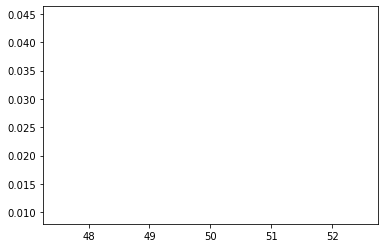

100 0.009681757513962297


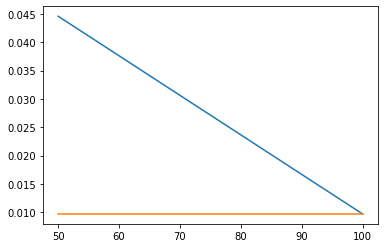

150 0.055420733074981646


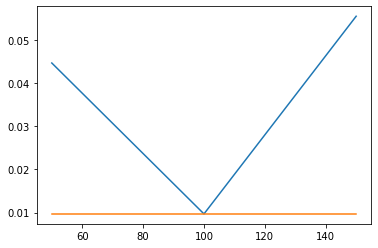

200 0.05509178220625056


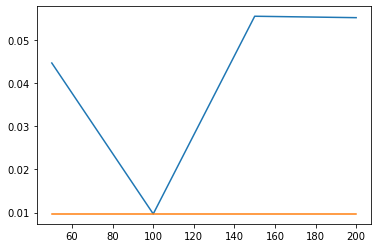

250 0.05474518346813319


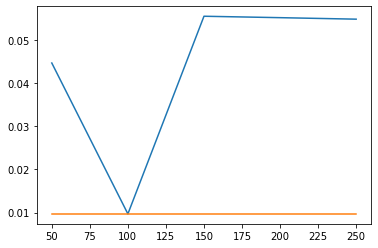

300 0.009681757513962297


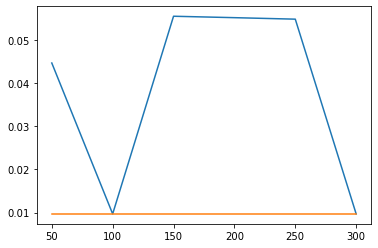

350 0.044601435975881364


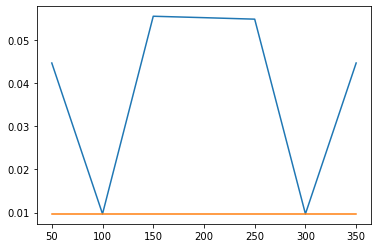

400 0.05211839427616386


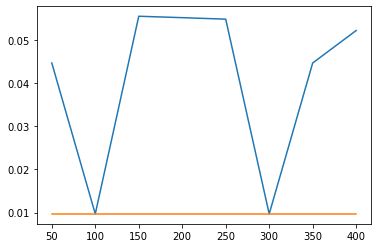

450 0.009681757513962297


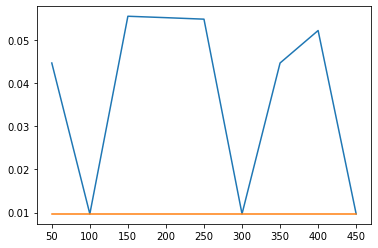

500 0.05438374669945556


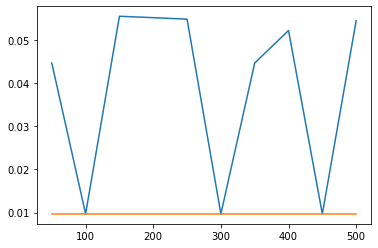

550 0.044601435975881364


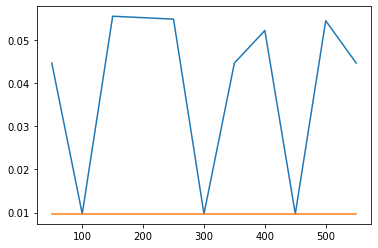

600 0.009681757513962297


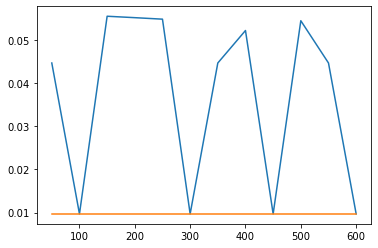

650 0.05474518346813319


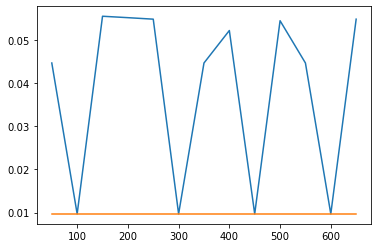

700 0.05509178220625056


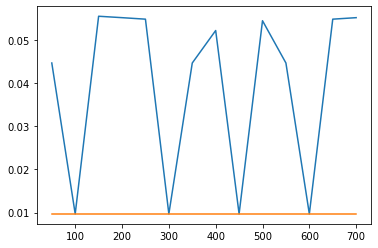

750 0.009681757513962297


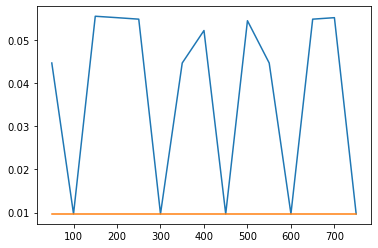

800 0.044601435975881364


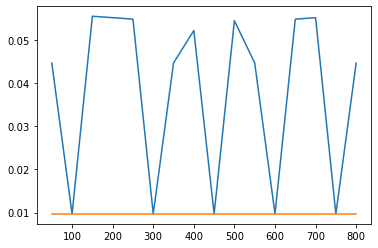

850 0.044601435975881364


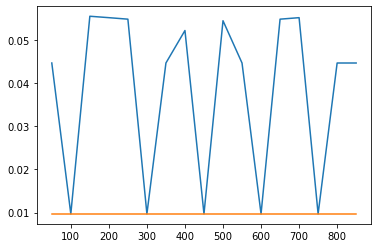

900 0.009681757513962297


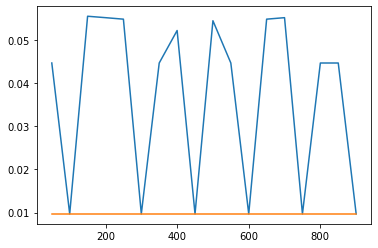

950 0.587085850261354


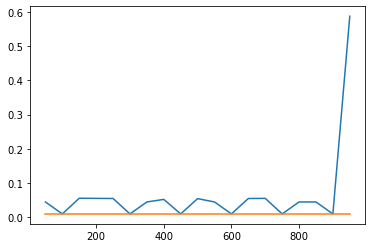

1000 0.05211839427616386


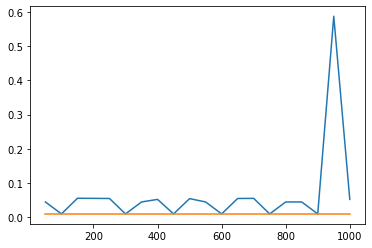

In [46]:
import matplotlib.pyplot as plt
iterations = 50
population = 50
bounds = [(0, 1) for i in range(len(original[0]))]
x = []
y = []
err = []
while(iterations<=1000):
    pso = PSO(sammon_error, original, bounds, population, iterations, 2)
    temp = pso.get_result()
    print(iterations, temp['error'])
#     print('\n')
    x.append(iterations)
    y.append(temp['error'])
    err.append(best_error)
    plt.plot(x, y)
    plt.plot(x, err)
    plt.show()
#     res.append(temp)

#     res = sorted(res, key=itemgetter('error'))
    iterations+=50